# Make MTH5 from QF data

This notebook demonstrates how to make a simple MTH5 from QF data.

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from mt_metadata.timeseries import Magnetic, Run, Station, Survey
from mt_metadata.timeseries.filters import (
    ChannelResponseFilter,
    FrequencyResponseTableFilter,
)
from mth5.mth5 import MTH5
from mth5.timeseries import ChannelTS, RunTS

2023-04-18 12:17:54,085 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


## Make Filters

These are ANT4 induction coils that come with a frequency-amplitude-phase calibration.  Also are the data logger response of the analog board and the digitizer.

#### ANT4

In [3]:
ant4_fn = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\calibration_responses\1304_0_0.csv"
)

ant4_df = pd.read_csv(ant4_fn, header=0)
ant4_fap = FrequencyResponseTableFilter()
ant4_fap.frequencies = ant4_df["Frequency [Hz]"].to_numpy()
ant4_fap.amplitudes = ant4_df["Amplitude [V/nT]"].to_numpy()
ant4_fap.phases = np.deg2rad(ant4_df["phase [degrees]"].to_numpy())
ant4_fap.units_out = "volts"
ant4_fap.units_in = "nanotesla"
ant4_fap.name = "ant4_response"

#### Analog Filter

In [4]:
analog_fn = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\calibration_responses\0101_1_0.csv"
)

analog_df = pd.read_csv(analog_fn, header=0)
analog_fap = FrequencyResponseTableFilter()
analog_fap.frequencies = analog_df["Frequency [Hz]"].to_numpy()
analog_fap.amplitudes = analog_df["Amplitude [V_out/V_in]"].to_numpy()
analog_fap.phases = np.deg2rad(analog_df["Phase [degrees]"].to_numpy())
analog_fap.units_out = "volts"
analog_fap.units_in = "volts"
analog_fap.name = "analog_response"

#### Digitial Filter

In [5]:
digital_fn = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\calibration_responses\0000_0_0_50.csv"
)

digital_df = pd.read_csv(digital_fn, header=0)
digital_fap = FrequencyResponseTableFilter()
digital_fap.frequencies = digital_df["Frequency [Hz]"].to_numpy()
digital_fap.amplitudes = digital_df["Amplitude [V_out_symm / V_in_symm]"].to_numpy()
digital_fap.phases = np.deg2rad(digital_df["Phase [degrees]"].to_numpy())
digital_fap.units_out = "volts"
digital_fap.units_in = "volts"
digital_fap.name = "digital_response"

#### Channel Response Filter

The channel response filter is coil response, digital response, analog response.

In [6]:
channel_response = ChannelResponseFilter(
    filters_list=[ant4_fap, digital_fap, analog_fap]
)

C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_metadata\mt_metadata\timeseries\filters\filter_base.py:294: RuntimeWarning: divide by zero encountered in double_scalars
  1 - np.log10(cr_window.min()) / np.log10(cr_window.max())


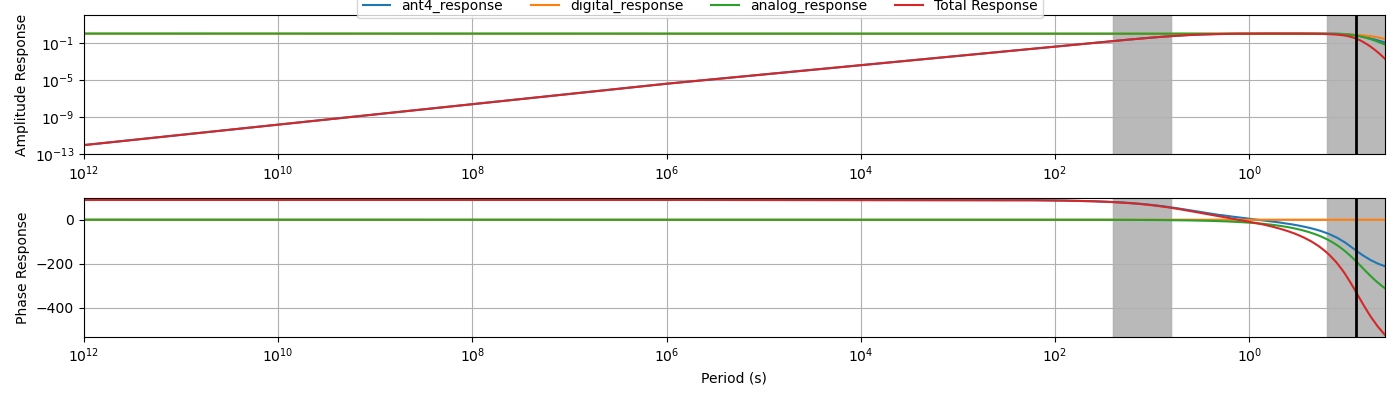

In [7]:
channel_response.plot_response(digital_fap.frequencies)

## Load Data

The way the data are store are in folder for north and east magnetometers, then folders for the station, then as day files as numpy arrays.

- orientation
   - station
      - day files (*.npy*)


#### Survey Metadata

In [8]:
survey_metadata = Survey(id="RR")
survey_metadata.acquired_by.name = "Quakefinder"

#### HX Metadata

In [10]:
hx_metadata = Magnetic(component="hx")
hx_metadata.time_period.start = "2021-04-04T00:00:00"
hx_metadata.time_period.end = hx_metadata.time_period._start_dt + (3600 * 24 * 14)
hx_metadata.sample_rate = 50
hx_metadata.filter.name = ["ant4_response", "digital_response", "analog_response"]
hx_metadata.filter.applied = [False, False, False]
hx_metadata.units = "volts"
hx_metadata.measurement_azimuth = 0
hx_metadata.sensor.id = "1310"
hx_metadata.sensor.manufacturer = "Zonge International"
hx_metadata.sensor.model = "ANT4"
hx_metadata.sensor.type = "induction coil"

#### HY Metadata

In [11]:
hy_metadata = Magnetic(component="hy")
hy_metadata.time_period.start = "2021-04-04T00:00:00"
hy_metadata.time_period.end = hy_metadata.time_period._start_dt + (3600 * 24 * 14)
hy_metadata.sample_rate = 50
hy_metadata.filter.name = ["ant4_response", "digital_response", "analog_response"]
hy_metadata.filter.applied = [False, False, False]
hy_metadata.units = "volts"
hy_metadata.measurement_azimuth = 90
hy_metadata.sensor.id = "1310"
hy_metadata.sensor.manufacturer = "Zonge International"
hy_metadata.sensor.model = "ANT4"
hy_metadata.sensor.type = "induction coil"

### Loop through stations

In [12]:
rr_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR")

In [13]:
n_stations = sorted(list(rr_path.joinpath("n_mag_volts_rs50").iterdir()))
e_stations = sorted(list(rr_path.joinpath("e_mag_volts_rs50").iterdir()))

In [14]:
m = MTH5()
m.open_mth5(rr_path.joinpath("qf_rr.h5"))
survey_group = m.add_survey("RR", survey_metadata=survey_metadata)

2023-04-18 12:18:22,600 [line 672] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5 in mode a


In [16]:
%%time
for n_station, e_station in zip(n_stations, e_stations):
    n_fn_list = sorted(list(n_station.glob("*.npy")))
    e_fn_list = sorted(list(e_station.glob("*.npy")))
    
    # Metdata
    station_id = n_station.name
    run_id = f"{station_id}a"
    station_metadata = Station(id=station_id)
    run_metadata = Run(id=run_id)

    # load hx
    hx = np.load(n_fn_list[0])
    for n_fn in n_fn_list[1:]:
        hx = np.append(hx, np.load(n_fn))
    hxts = ChannelTS(
        "magnetic",
        data=hx,
        channel_metadata=hx_metadata,
        channel_response_filter=channel_response,
        survey_metadata=survey_metadata,
        station_metadata=station_metadata,
        run_metadata=run_metadata,
    )
    
    # load hy
    hy = np.load(e_fn_list[0])
    for e_fn in e_fn_list[1:]:
        hy = np.append(hy, np.load(e_fn))
    hyts = ChannelTS(
        "magnetic",
        data=hy,
        channel_metadata=hy_metadata,
        channel_response_filter=channel_response,
        survey_metadata=survey_metadata,
        station_metadata=station_metadata,
        run_metadata=run_metadata,
    )

    # make a RunTS
    run_ts = RunTS(
        [hxts, hyts],
        run_metadata=run_metadata,
        station_metadata=station_metadata,
        survey_metadata=survey_metadata,
    )

    # Add groups
    station_group = survey_group.stations_group.add_station(station_id, station_metadata=station_metadata)
    run_group = station_group.add_run(run_id, run_metadata=run_metadata)
    run_group.from_runts(run_ts)

Wall time: 45.3 s


In [38]:
m.close_mth5()

2023-04-18 12:57:26,470 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5


In [19]:
m = MTH5()
m.open_mth5(rr_path.joinpath("qf_rr.h5"))

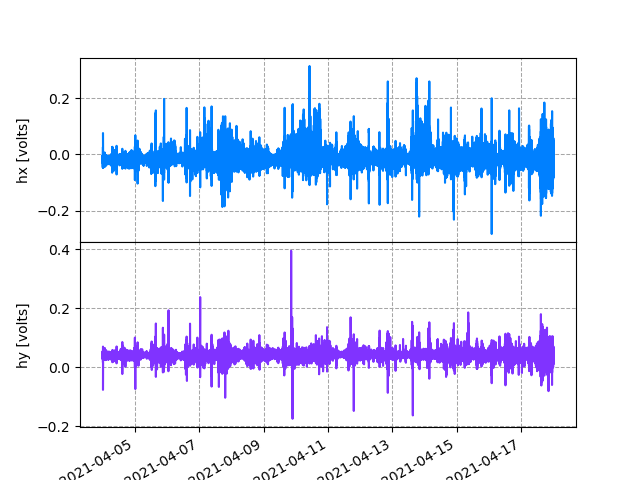

In [36]:
run1 = m.get_run("0863", "0863a", "RR")
run1_ts = run1.to_runts()
run1_ts.plot()

2023-04-18 12:35:58,531 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 12:36:02,317 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 12:36:05,662 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 12:36:23,956 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 12:36:27,765 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 12:36:31,396 [line 222] mt_me

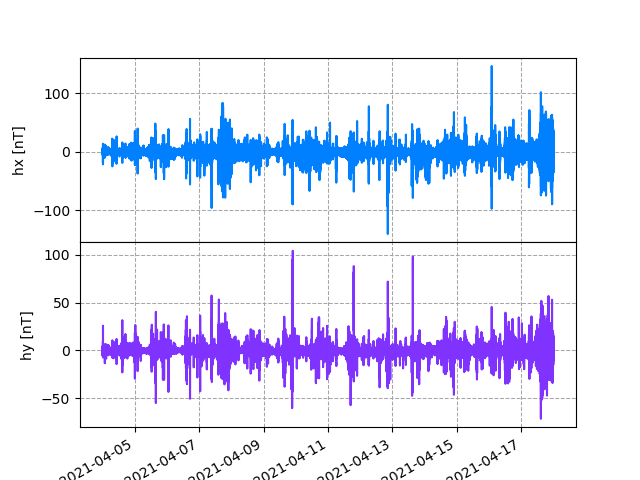

In [37]:
calibrated_run = run1_ts.calibrate()
calibrated_run.plot()